# An enhanced WebDriver: manen's `Browser`

The module `manen.browser` defines several `Browser` classes such as `ChromeBrowser`. These classes inherits from `WebDriver` and are designed to only completes the original classes and not overwrite the base methods. These new methods are used for instanciation, DOMs exploration and some utils methods. This guide completes the documentation of these methods (that can be getting the help on the class `manen.browser.BrowserMixin`).

Note that all the browsers are not currently supported. To see the list of browser classes, you can use the values returned by `manen.browser.__all__`.

In [1]:
from manen.browser import __all__
__all__

('BraveBrowser', 'ChromeBrowser')

## Instanciating a browser

Each browser class implemented in `manen` provides the same additional methods compared to a WebDriver. One of the method is `initialize` which allows to instanciate a new browser with some common options:

- `proxy` that will be the proxies used in the browser for each request.
- `headless` to launch the browser in headless mode (without graphical interface).
- `driver_path` which is the path of the binary for the browser driver. Note that if no driver path is specified, `manen` will automatically get the driver compatible with the used browser (by using the method `{browser}.driver.get` which will download the driver file if needed)
- `window_size` which will the dimensions in pixel of the created browser window.

In [2]:
from manen.browser import ChromeBrowser
browser = ChromeBrowser.initialize(proxy=None, headless=False, window_size=(1152, 864))

Given that a browser class just inherits from a `WebDriver`, all the usual methods such as `get`, `save_screenshot`, `find_element(s)*`.

In [3]:
browser.get("https://kodaho.github.io/manen")

In [4]:
from selenium.webdriver.common.by import By
for elt in browser.find_elements(By.CSS_SELECTOR, "div.sidebar-tree>ul>li.toctree-l1>a"):
    print(f"{elt.get_attribute('innerText'):25} -> {elt.get_property('href')}")

About the project         -> https://kodaho.github.io/manen/about.html
Installation              -> https://kodaho.github.io/manen/installation.html
User Guide                -> https://kodaho.github.io/manen/user_guide.html
Going deeper into manen   -> https://kodaho.github.io/manen/manen/manen.html
Changelog                 -> https://kodaho.github.io/manen/changelog.html
Contributing              -> https://kodaho.github.io/manen/contributing.html


## Exploring the DOM

Retrieving web elements is usually done with the methods `find_element` or `find_elements`. Even if these methods fulfil several use cases, the retrieval of web elements sometimes requires to handle more cases; the function `manen.finder.find()` has been designed to answer this problematic and has been integrated to the browser class. Please refer to the documentation of this function to get the exhaustive list of what can be done with this function. The `find` method of a browser and the function in `manen.finder` have approximately the same signature: the only differences is that it will retrieve by default all the elements matching the given selectors.

Let's dig into the `find()` method, with an example by exploring the results matching the query "selenium" on PyPI.

In [5]:
browser.get("https://pypi.org/search/?q=selenium")

In [6]:
NAME_SELECTOR = "ul[aria-label='Search results']>li>a>h3>span.package-snippet__name"
elements = browser.find(NAME_SELECTOR) # equivalent to browser.find(NAME_SELECTOR, many=True)
for element in elements:
    print(element.get_attribute('innerText'))

selenium
selenium-wire
selenium-generator
Selenium-Screenshot
auto-selenium
django-selenium
selenium-robot
selenium_wrapper
datetime-selenium
fasttest-selenium
selenium-findtext
selenium-pinterest
selenium-elements
nose-selenium
ctreport-selenium
masonite-selenium
play-selenium
amazon-selenium
selenium-configurator
selenium-firefox


If you want to get only one hit, you can set the keyword argument `many` to `False`.

In [7]:
browser.find("xpath://*[@id='content']//form/div[1]/div[1]/p", many=False).get_attribute('innerText')

'1,436 projects for "selenium"'

The function has been designed to be scalable, meaning that instead of searching inside the whole page, you can search inside a specific element.

In [8]:
results = browser.find("ul[aria-label='Search results'] li")

Let's search the name of the first package in the first results.

In [9]:
browser.find("h3 span.package-snippet__name", many=False, inside=results[0]).get_property('innerText')

'selenium'

If the `inside` keyword argument is a list instead of a single element, it will return one results for each element in the list.

In [10]:
elements_name = browser.find("h3 span.package-snippet__name", many=False, inside=results)
elements_name[:5]

[<selenium.webdriver.remote.webelement.WebElement (session="a49cbf2183c8851614afed4cc983838f", element="2031bbcb-bf43-47a4-afde-3e5020003bd6")>,
 <selenium.webdriver.remote.webelement.WebElement (session="a49cbf2183c8851614afed4cc983838f", element="a2aa299d-6159-45d9-8b9c-fb026b517782")>,
 <selenium.webdriver.remote.webelement.WebElement (session="a49cbf2183c8851614afed4cc983838f", element="a7686b0d-7494-450a-865e-8f2fca2a93c8")>,
 <selenium.webdriver.remote.webelement.WebElement (session="a49cbf2183c8851614afed4cc983838f", element="394fab67-20fb-407b-8da2-2d5a0010d9e7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="a49cbf2183c8851614afed4cc983838f", element="ca69129b-bf8e-4854-a707-f05a3d9972b5")>]

By default, `manen` will raise a `ElementNotFound` exception if the selectors specified match no elements in the page.

In [11]:
browser.find("css:fake-selector")

ElementNotFound: Unable to find inside document an element matching the selectors :
> css:fake-selector

Context of the exception:
- Title page: Search results · PyPI
- URL: https://pypi.org/search/?q=selenium

To avoid raising an error, you can specify a default value to be returned if any element is found.

In [12]:
browser.find('css:fake-selector', default=None)

Note that the browser has a method `lookup` that is equivalent to the `find()` method, except that it will never raise an error; the default value for an unfound element is, by default, `None`.

By specifying the `wait` keyword argument, you can specify the number of seconds to wait until trying to locate the element(s).

In [13]:
%%time
browser.find('css:fake-selector', wait=3, default=None)

CPU times: user 13.8 ms, sys: 3.33 ms, total: 17.1 ms
Wall time: 3.08 s


Another use case supported by `manen` is trying several different selectors to locate an element. Just specify a list of selectors instead of just a selector. It will try all the selectors by order and return an element as soon as a selector hits a result.

In [14]:
browser.find(['fake-link-selector', 'a'], many=False).get_property('href')

'https://pypi.org/search/?q=selenium#content'

In order to help the development of your project, the browser has a method `highlight` that will highlight all the elements matching the specified selectors.

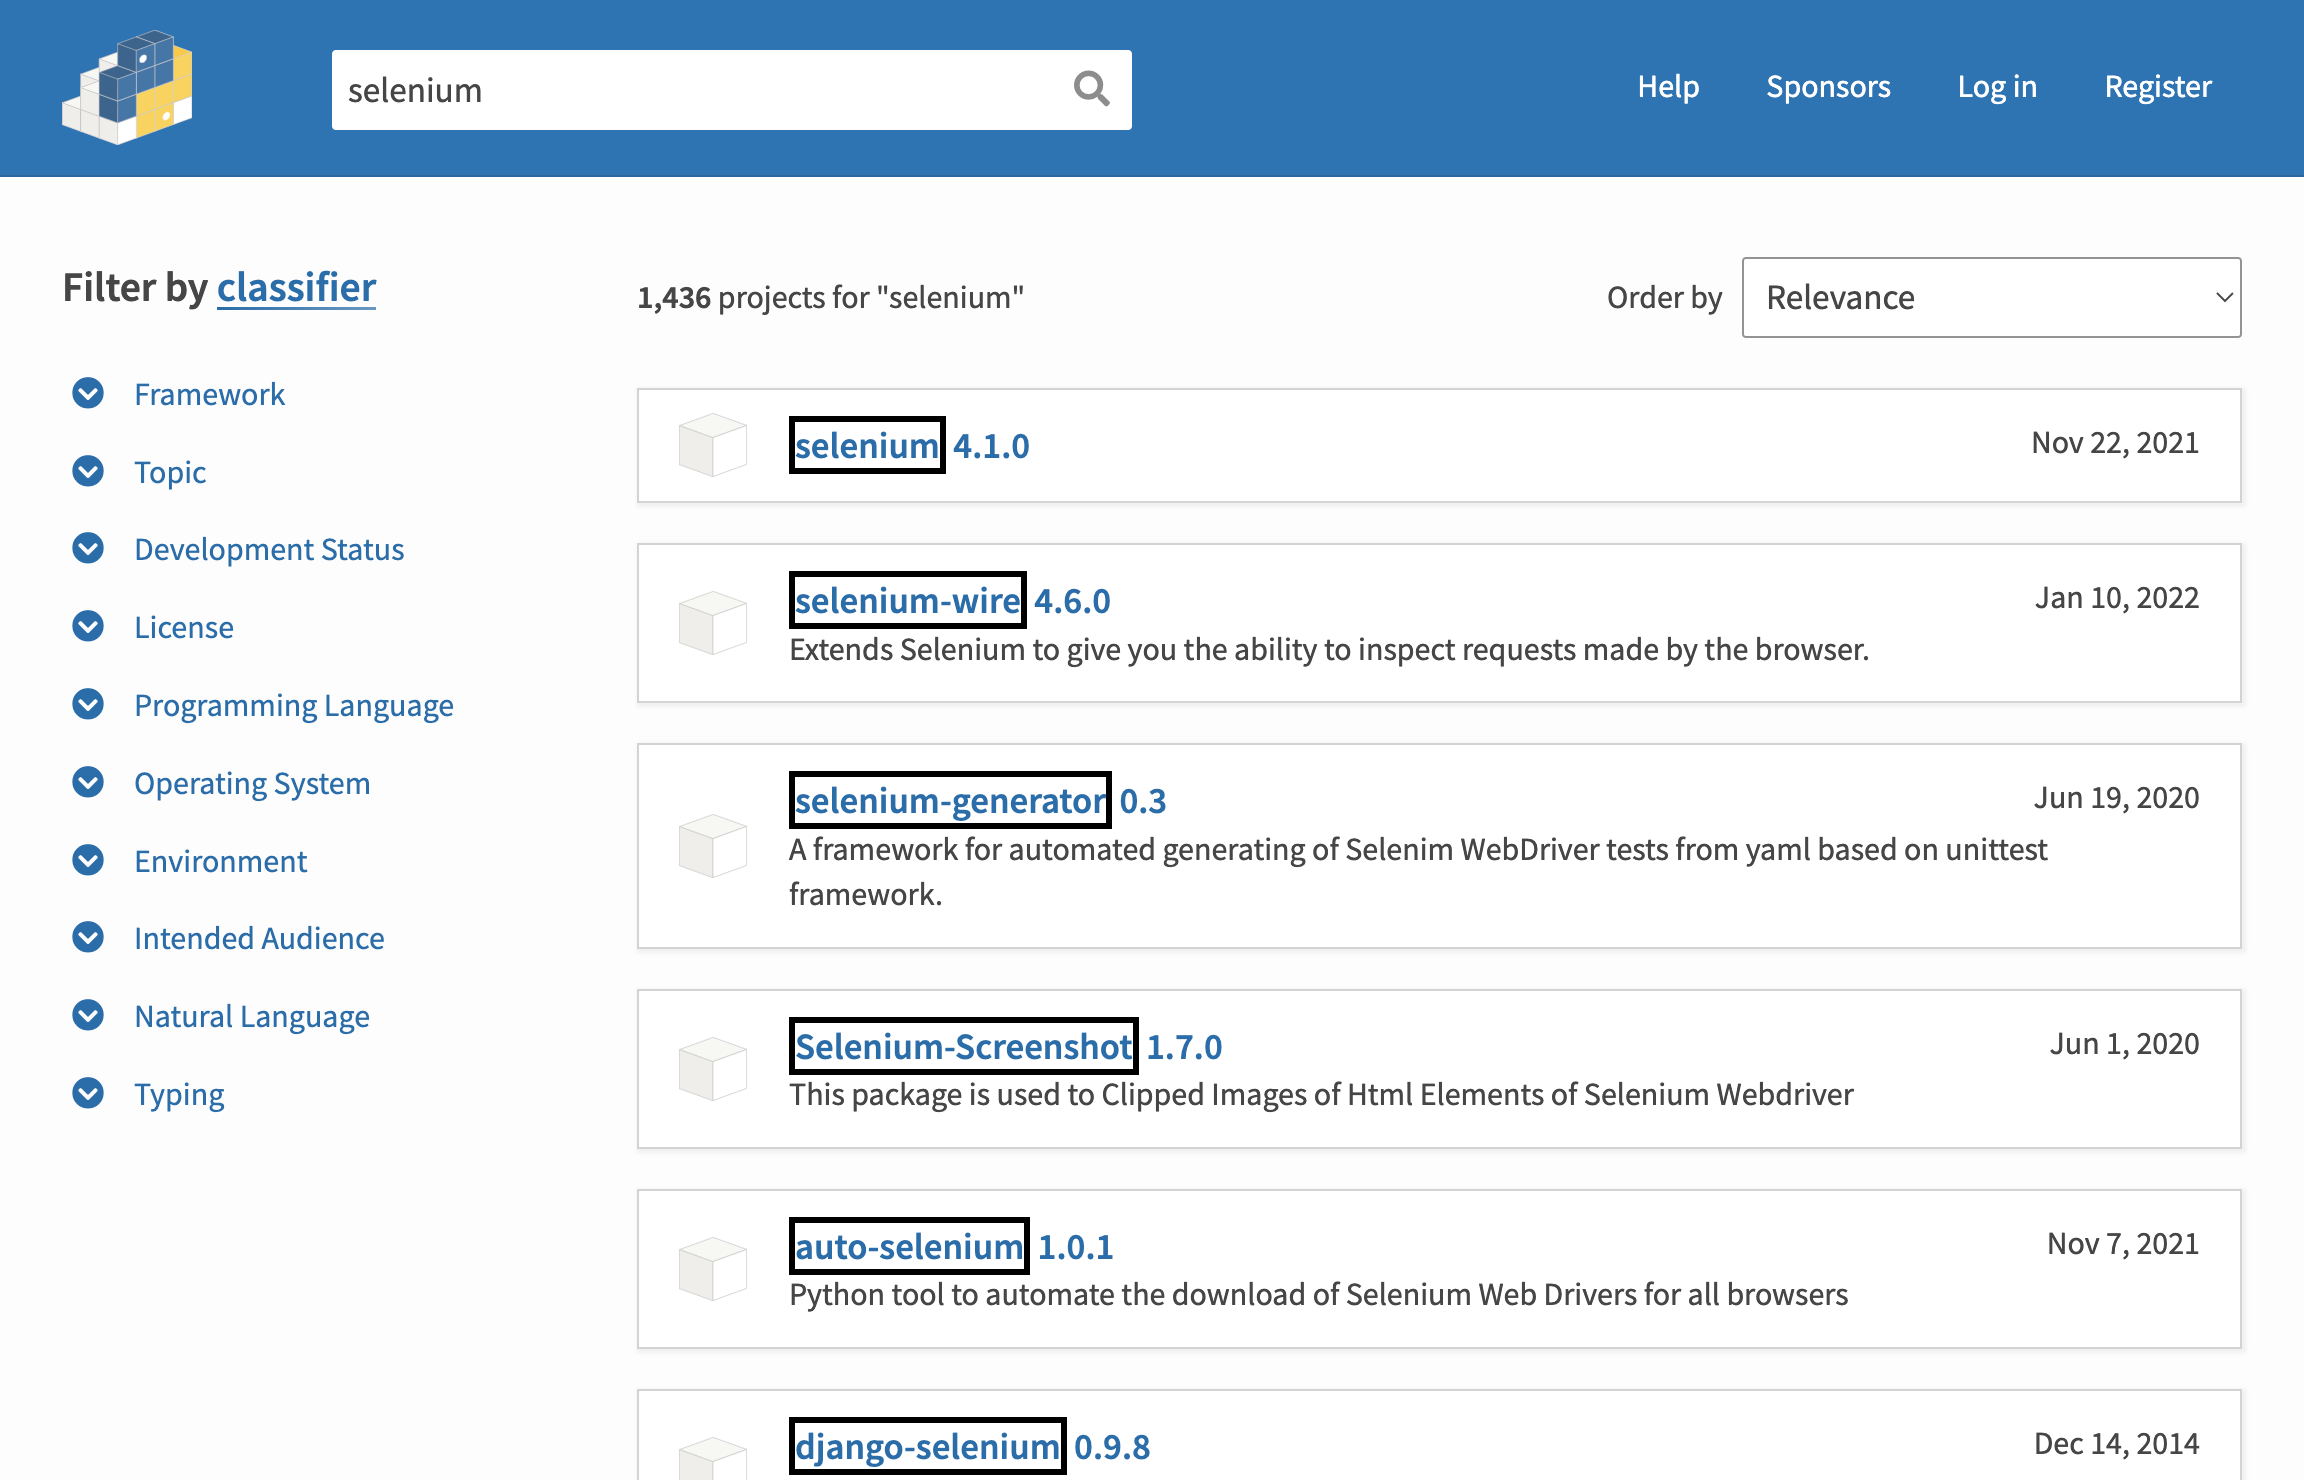

In [15]:
from tempfile import NamedTemporaryFile
from IPython.display import Image

browser.highlight(NAME_SELECTOR)
with NamedTemporaryFile() as f:
    browser.save_screenshot(f.name + '.png')
    highlight_screenshot = Image(f.name + '.png')
highlight_screenshot

## Cookies management

One of the feature offered by `manen`'s `Browser` is an interface for cookies. With a `selenium.WebDriver`, you will have to use the methods `get_cookies`, `add_cookie` and `delete_all_cookies`. With a `Browser`, you can interact with cookies through the properties `cookies`.

In [16]:
browser.get("https://httpbin.org/cookies/set/test/manen")
browser.cookies

[{'domain': 'httpbin.org',
  'httpOnly': False,
  'name': 'test',
  'path': '/',
  'secure': False,
  'value': 'manen'}]

In [17]:
# browser.cookies = list_of_cookies_dict

In [18]:
del browser.cookies
assert len(browser.get_cookies()) == 0

In [19]:
browser.quit()